# Using RNNs to Predict Cryptocurrency Price Fluctuations

Import Requests library to gatehr data, the DS classics and Keras for the RNNs

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD, Adam

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-04 22:17:29.930002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
import seaborn as sns

In [16]:
def get_historic_rates(product_id, start, end, granularity):
    """
    Fetches historic rates for a product. Rates are returned in grouped buckets.
    :param product_id: Product id (e.g., 'BTC-USD')
    :param start: Start time in ISO 8601 format
    :param end: End time in ISO 8601 format
    :param granularity: Desired timeslice in seconds
    """
    url = f'https://api.exchange.coinbase.com/products/{product_id}/candles'
    params = {
        'start': start,
        'end': end,
        'granularity': granularity
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f'Failed to fetch data from Coinbase Advanced API: {response.text}')
    data = response.json()
    df = pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

In [15]:
def get_trading_pairs():
    """
    Fetches all available trading pairs on Coinbase Advanced API.
    """
    url = 'https://api.exchange.coinbase.com/products'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f'Failed to fetch data from Coinbase Advanced API: {response.text}')
    data = response.json()
    df = pd.DataFrame(data)
    return df

In [8]:
pairs = get_trading_pairs()
pairs.to_csv('trading_pairs.csv')

In [ ]:
product_id = 'BTC-USD'
start = (datetime.now() - timedelta(days=75)).isoformat()
end = datetime.now().isoformat()
granularity = 21600  # 1/4th day data

# Get historic rates
btc_data = get_historic_rates(product_id, start, end, granularity)
print(btc_data)

In [19]:
def get_historical_hourly(product_id, days):
    """
    Fetches historical hourly data for a product. Rates are returned in grouped buckets.
    :param product_id: Product id (e.g., 'BTC-USD')
    :param days: Number of days to fetch data for
    """
    now = datetime.now()
    start = now - timedelta(days=days)
    end = start + timedelta(days=12.5)
    granularity = 3600  # 1 hour data
    responses = []
    while start < now:
        data = get_historic_rates(product_id, start.isoformat(), end.isoformat(), granularity)
        responses.append(data)
        start = end
        end = start + timedelta(days=12.5)
    return pd.concat(responses)

In [20]:
arb = get_historical_hourly('BTC-USD', 400)
arb

Fetching data from 2022-10-30 23:31:30.912792 to 2022-11-12 11:31:30.912792
Fetching data from 2022-11-12 11:31:30.912792 to 2022-11-24 23:31:30.912792
Fetching data from 2022-11-24 23:31:30.912792 to 2022-12-07 11:31:30.912792
Fetching data from 2022-12-07 11:31:30.912792 to 2022-12-19 23:31:30.912792
Fetching data from 2022-12-19 23:31:30.912792 to 2023-01-01 11:31:30.912792
Fetching data from 2023-01-01 11:31:30.912792 to 2023-01-13 23:31:30.912792
Fetching data from 2023-01-13 23:31:30.912792 to 2023-01-26 11:31:30.912792
Fetching data from 2023-01-26 11:31:30.912792 to 2023-02-07 23:31:30.912792
Fetching data from 2023-02-07 23:31:30.912792 to 2023-02-20 11:31:30.912792
Fetching data from 2023-02-20 11:31:30.912792 to 2023-03-04 23:31:30.912792
Fetching data from 2023-03-04 23:31:30.912792 to 2023-03-17 11:31:30.912792
Fetching data from 2023-03-17 11:31:30.912792 to 2023-03-29 23:31:30.912792
Fetching data from 2023-03-29 23:31:30.912792 to 2023-04-11 11:31:30.912792
Fetching dat

,low,high,open,close,volume
time,,,,,
2022-11-12 11:00:00,16749.16,16852.24,16801.34,16831.53,727.352291
2022-11-12 10:00:00,16767.05,16925.14,16817.34,16802.00,1022.484899
2022-11-12 09:00:00,16750.02,16855.16,16796.01,16817.36,933.586535
2022-11-12 08:00:00,16681.71,16860.00,16778.76,16796.04,870.178108
2022-11-12 07:00:00,16715.29,16829.25,16718.19,16777.60,996.575338
...,...,...,...,...,...
2023-11-22 16:00:00,36375.01,36585.44,36487.22,36475.20,577.669506
2023-11-22 15:00:00,36241.00,36641.20,36403.43,36487.20,877.767271
2023-11-22 14:00:00,36288.13,36662.53,36606.71,36404.05,644.787537


In [21]:
arb.to_csv('BTC-USD.csv')

In [22]:
btc_data = pd.read_csv('BTC-USD.csv')
btc_data['time'] = pd.to_datetime(btc_data['time'])
btc_data.set_index('time', inplace=True)

In [24]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data['close'].values.reshape(-1,1))

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]


In [25]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [28]:
look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X train: ', X_train)
print('y train: ', y_train)
print('X test: ', X_test)
print('y test: ', y_test)

X train:  [[[0.04539887]
  [0.04428049]
  [0.04486221]
  ...
  [0.02053273]
  [0.0180604 ]
  [0.02303158]]

 [[0.04428049]
  [0.04486221]
  [0.04405477]
  ...
  [0.0180604 ]
  [0.02303158]
  [0.00981473]]

 [[0.04486221]
  [0.04405477]
  [0.04335639]
  ...
  [0.02303158]
  [0.00981473]
  [0.00821082]]

 ...

 [[0.41620001]
  [0.41831445]
  [0.41757252]
  ...
  [0.39683868]
  [0.39615091]
  [0.40339181]]

 [[0.41831445]
  [0.41757252]
  [0.41677681]
  ...
  [0.39615091]
  [0.40339181]
  [0.40191023]]

 [[0.41757252]
  [0.41677681]
  [0.41544975]
  ...
  [0.40339181]
  [0.40191023]
  [0.40076571]]]
y train:  [0.00981473 0.00821082 0.00231062 ... 0.40191023 0.40076571 0.39721893]
X test:  [[[0.399995  ]
  [0.39826118]
  [0.39825058]
  ...
  [0.38246937]
  [0.38051513]
  [0.38211829]]

 [[0.39826118]
  [0.39825058]
  [0.39079267]
  ...
  [0.38051513]
  [0.38211829]
  [0.38626271]]

 [[0.39825058]
  [0.39079267]
  [0.38788783]
  ...
  [0.38211829]
  [0.38626271]
  [0.38678838]]

 ...

 [[0.

In [29]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back,1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

2023-12-05 00:11:46.581764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 00:11:46.582914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 00:11:46.583577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


2023-12-05 00:14:11.237857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 00:14:11.239025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 00:14:11.239673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

238/238 [==============================] - 7s 22ms/step - loss: 0.0028
Epoch 2/100
238/238 [==============================] - 5s 22ms/step - loss: 1.7474e-04
Epoch 3/100
238/238 [==============================] - 5s 22ms/step - loss: 1.6820e-04
Epoch 4/100
238/238 [==============================] - 5s 22ms/step - loss: 1.5369e-04
Epoch 5/100
238/238 [==============================] - 5s 22ms/step - loss: 1.2966e-04
Epoch 6/100
238/238 [==============================] - 5s 22ms/step - loss: 1.1838e-04
Epoch 7/100
238/238 [==============================] - 5s 22ms/step - loss: 1.0102e-04
Epoch 8/100
238/238 [==============================] - 5s 22ms/step - loss: 1.0081e-04
Epoch 9/100
238/238 [==============================] - 5s 22ms/step - loss: 1.0078e-04
Epoch 10/100
238/238 [==============================] - 5s 22ms/step - loss: 7.9714e-05
Epoch 11/100
238/238 [==============================] - 5s 22ms/step - loss: 7.0079e-05
Epoch 12/100
238/238 [==============================] - 5

In [31]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

2023-12-05 00:24:02.179370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 00:24:02.180477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 00:24:02.181115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

59/59 [==============================] - 0s 8ms/step


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate RMSE, MAE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
train_mae = mean_absolute_error(y_train_inv[0], train_predict[:,0])
test_mae = mean_absolute_error(y_test_inv[0], test_predict[:,0])
print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)
print('Train MAE: ', train_mae)
print('Test MAE: ', test_mae)
print('MSE percentage: ', (test_rmse / btc_data['close'].mean()) * 100)

Train RMSE:  216.86000627785955
Test RMSE:  464.0006218298573
Train MAE:  112.46726025935655
Test MAE:  260.64553292260626
MSE percentage:  1.77837970331222


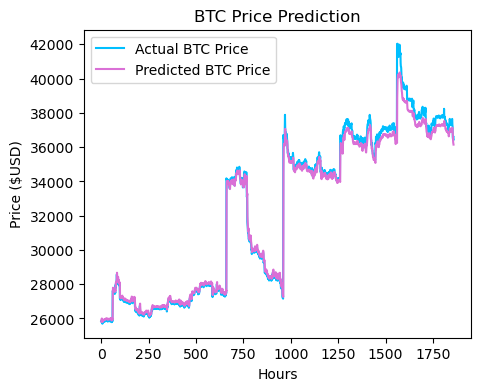

In [47]:
# Plot the results
plt.figure(figsize=(5,4))
plt.plot(y_test_inv[0], color='deepskyblue', label='Actual BTC Price')
plt.plot(test_predict[:,0], color='orchid', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Hours')
plt.ylabel('Price ($USD)')
plt.legend()
plt.show()

/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

<Axes: >

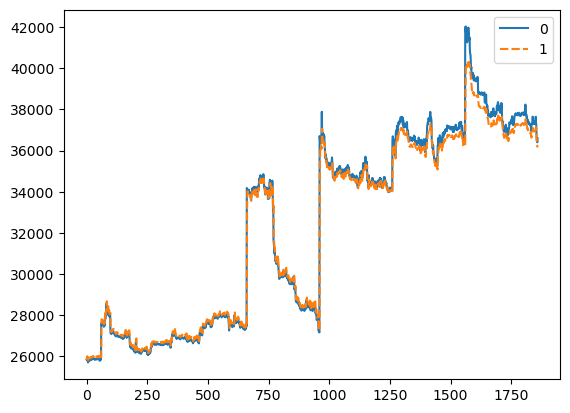

In [45]:
sns.lineplot(data=[y_test_inv[0], test_predict[:,0]])

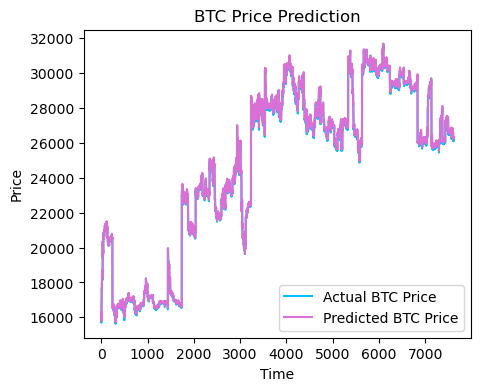

In [48]:
# Plot the results
plt.figure(figsize=(5,4))
plt.plot(y_train_inv[0], color='deepskyblue', label='Actual BTC Price')
plt.plot(train_predict[:,0], color='orchid', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

/var/folders/7k/6nbtrgkx3g56v2743d5zs9q00000gn/T/ipykernel_90075/847934238.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_inv[0] - test_predict[:,0], bins=500, kde=True)
/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/crypto_rnns/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu

<Axes: ylabel='Density'>

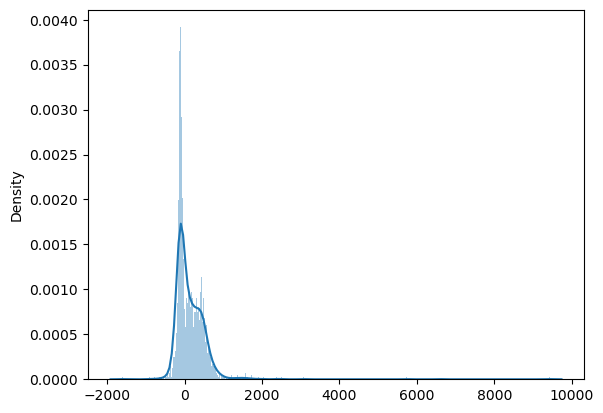

In [50]:
sns.distplot(y_test_inv[0] - test_predict[:,0], bins=500, kde=True)

In [67]:
# Start with the last `look_back` days of the training data
last_train_batch = train_data[-look_back:]
current_batch = last_train_batch.reshape((1, look_back, 1))

# Predict 25 days into the future
future_periods = 500
predicted_prices = []

for i in range(future_periods):    
    # Get the next predicted price
    prediction = model.predict(current_batch)[0]
    print(prediction)
    predicted_price = prediction[0]
    # Append the prediction to the list
    predicted_prices.append(predicted_price) 
    
    # Update the batch to include the new prediction and drop the oldest value
    current_batch = np.append(current_batch[:,1:,:],[[prediction]],axis=1)

# Invert the predictions to original scale
predicted_prices_original_scale = scaler.inverse_transform([predicted_prices])


1/1 [==============================] - 0s 21ms/step
[0.4046784]
1/1 [==============================] - 0s 19ms/step
[0.4086192]
1/1 [==============================] - 0s 16ms/step
[0.4126854]
1/1 [==============================] - 0s 17ms/step
[0.41683114]
1/1 [==============================] - 0s 16ms/step
[0.42103535]
1/1 [==============================] - 0s 16ms/step
[0.4252835]
1/1 [==============================] - 0s 17ms/step
[0.429564]
1/1 [==============================] - 0s 17ms/step
[0.43386734]
1/1 [==============================] - 0s 17ms/step
[0.4381855]
1/1 [==============================] - 0s 15ms/step
[0.44251135]
1/1 [==============================] - 0s 17ms/step
[0.4468388]
1/1 [==============================] - 0s 17ms/step
[0.45116222]
1/1 [==============================] - 0s 17ms/step
[0.45547676]
1/1 [==============================] - 0s 18ms/step
[0.4597777]
1/1 [==============================] - 0s 17ms/step
[0.46406084]
1/1 [=============================

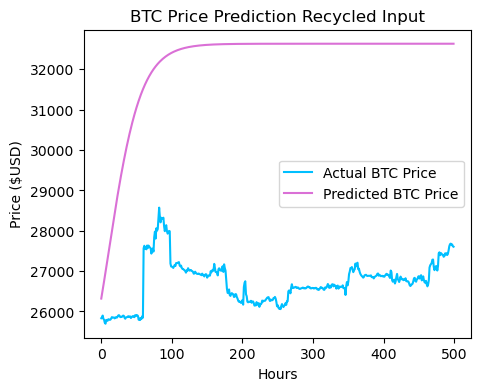

In [64]:

# Plot the results
plt.figure(figsize=(5,4))
plt.plot(y_test_inv[0][0:500], color='deepskyblue', label='Actual BTC Price')
plt.plot(predicted_prices_original_scale[0], color='orchid', label='Predicted BTC Price')
plt.title('BTC Price Prediction Recycled Input')
plt.xlabel('Hours')
plt.ylabel('Price ($USD)')
plt.legend()
plt.show()

1/1 [==============================] - 0s 14ms/step


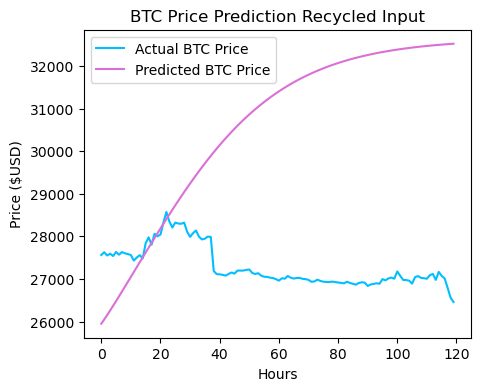

1/1 [==============================] - 0s 14ms/step


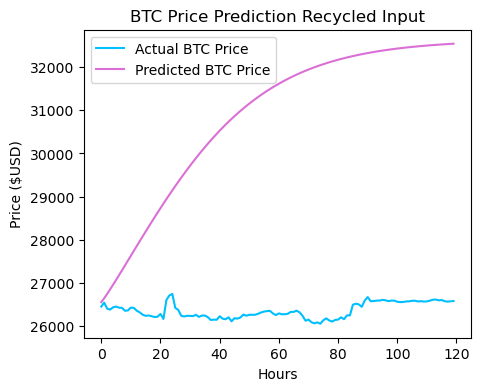

1/1 [==============================] - 0s 16ms/step


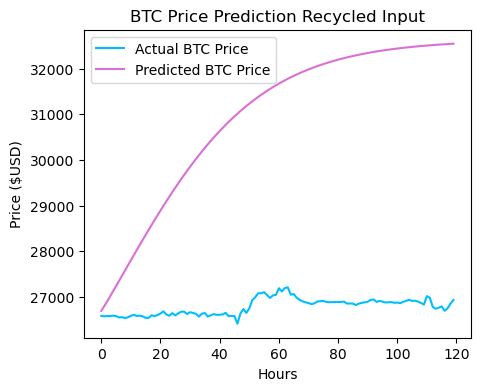

1/1 [==============================] - 0s 15ms/step


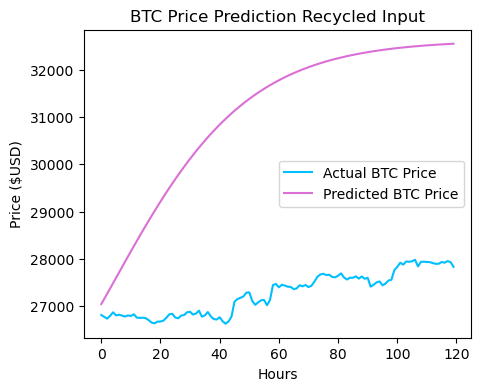

1/1 [==============================] - 0s 14ms/step


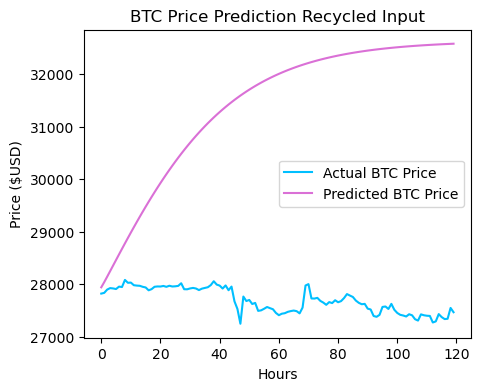

1/1 [==============================] - 0s 14ms/step


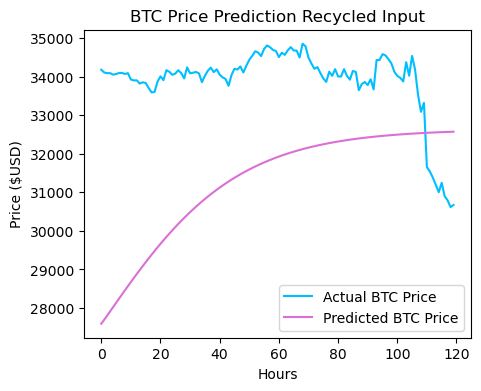

1/1 [==============================] - 0s 15ms/step


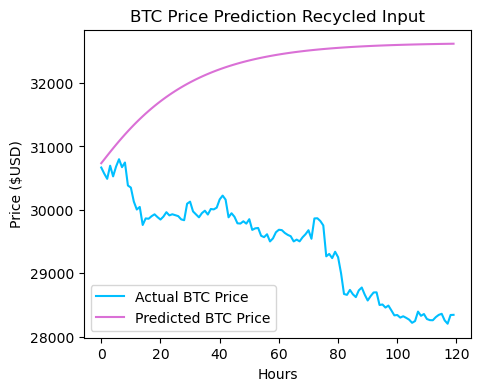

1/1 [==============================] - 0s 15ms/step


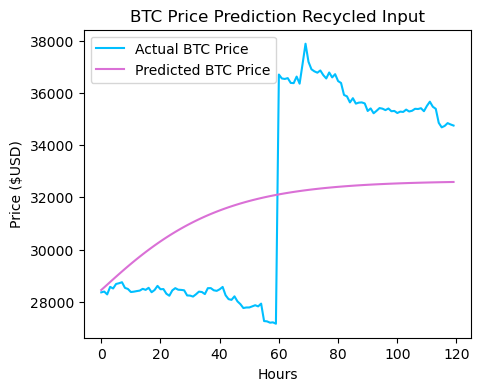

1/1 [==============================] - 0s 17ms/step


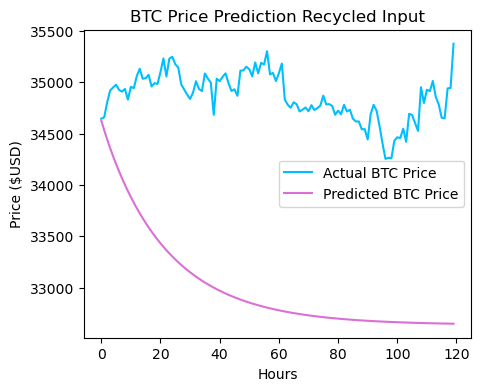

1/1 [==============================] - 0s 14ms/step


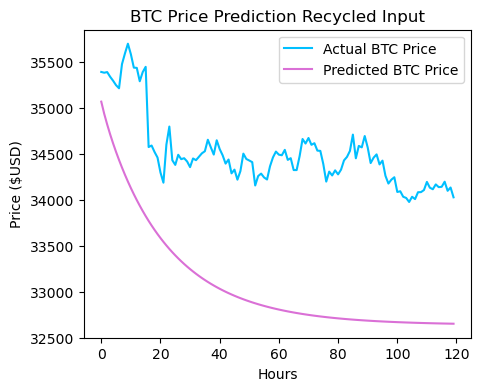

1/1 [==============================] - 0s 14ms/step


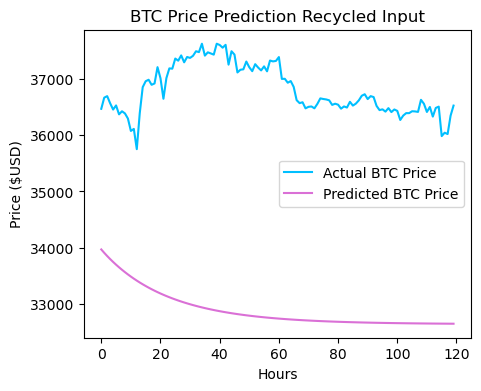

1/1 [==============================] - 0s 15ms/step


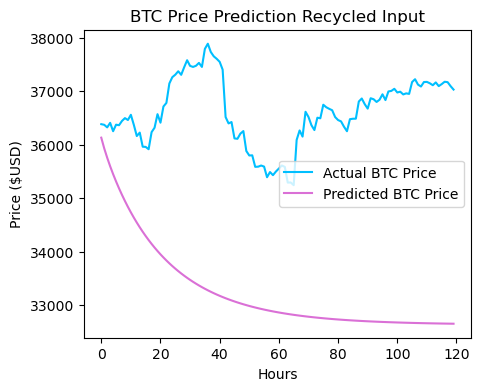

1/1 [==============================] - 0s 15ms/step


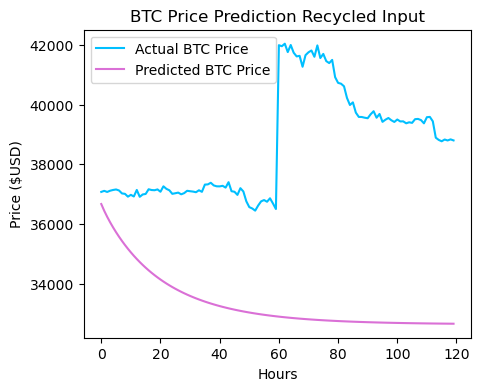

1/1 [==============================] - 0s 15ms/step


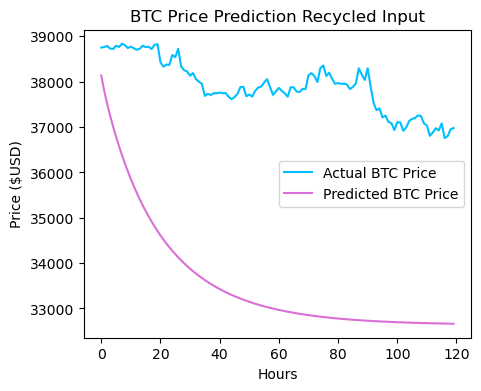

1/1 [==============================] - 0s 15ms/step


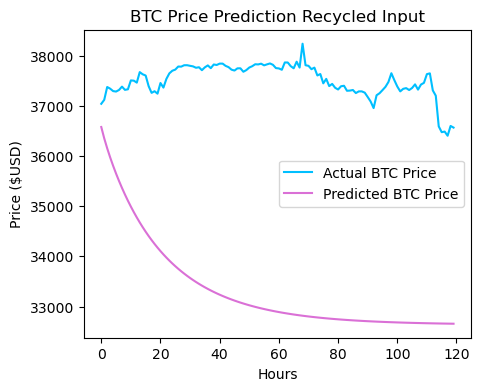

In [71]:
def predict_trend(lstm, data, look_back=60, predict=120):
    """
    Predicts the trend of a cryptocurrency price using a trained LSTM model.
    :param model: Trained LSTM model
    :param data: Data to predict trend for
    :param look_back: Number of previous data points to use for prediction
    """
    # Get the last `look_back` days of data
    last_data = data[-look_back:]
    # Scale the data to be values between 0 and 1 inclusive
    #last_data_scaled = scaler.transform(last_data.reshape(-1,1))
    # Reshape the data into a 3-dimensional array
    # The LSTM model expects the data to be shaped like: (# rows, # time steps, # features)
    last_data_scaled = last_data.reshape((1, look_back, 1))
    predictions = []

    for i in range(predict):    
        # Get the next predicted price
        next_prediction = lstm.predict(last_data_scaled)[0]
        # Append the prediction to the list
        predictions.append(next_prediction[0]) 
        # Update the batch to include the new prediction and drop the oldest value
        last_data_scaled = np.append(last_data_scaled[:,1:,:],[[next_prediction]],axis=1)

    # Invert the predictions to original scale
    predictions_unscaled = scaler.inverse_transform([predictions])
    return predictions_unscaled
    
# Split out test set into 120 hour chunks
test_data_chunks = [test_data[i:i+120] for i in range(0, len(test_data), 120)]

for i in range(len(test_data_chunks) - 1):
    future_prices = predict_trend(model, test_data_chunks[i], look_back=60, predict=120)
    plt.figure(figsize=(5,4))
    plt.plot(scaler.inverse_transform(test_data_chunks[i+1]), color='deepskyblue', label='Actual BTC Price')
    plt.plot(future_prices[0], color='orchid', label='Predicted BTC Price')
    plt.title('BTC Price Prediction Recycled Input')
    plt.xlabel('Hours')
    plt.ylabel('Price ($USD)')
    plt.legend()
    plt.show()

In [ ]:
test_data_days = [test_data[i:i+60] for i in range(0, len(test_data), 60)]

trends = []
for i in range(len(test_data_days) - 1):
    trend = predict_trend(model, test_data_days[i], look_back=60, predict=60)
    trends.append(trend[0])
    


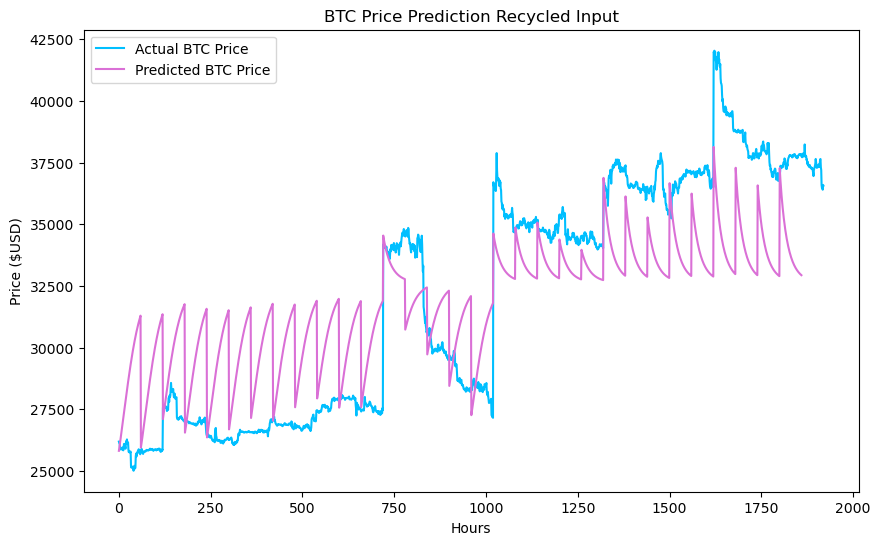

In [79]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(test_data), color='deepskyblue', label='Actual BTC Price')
plt.plot(np.concatenate(trends), color='orchid', label='Predicted BTC Price')
plt.title('BTC Price Prediction Recycled Input')
plt.xlabel('Hours')
plt.ylabel('Price ($USD)')
plt.legend()
plt.show()

In [77]:
trends

[array([25819.87718476, 25919.01394884, 26022.84932795, 26129.33500609,
        26237.83044185, 26347.92723109, 26459.30982455, 26571.720904  ,
        26684.94328341, 26798.78731848, 26913.09011967, 27027.70296178,
        27142.49521844, 27257.34334541, 27372.13009372, 27486.7515918 ,
        27601.09767282, 27715.07233426, 27828.57485217, 27941.51315856,
        28053.79203782, 28165.32099577, 28276.01347276, 28385.78448297,
        28494.54904054, 28602.22924181, 28708.74954381, 28814.03597737,
        28918.01614717, 29020.62552692, 29121.80431177, 29221.48797543,
        29319.62615594, 29416.16849132, 29511.06776721, 29604.2830645 ,
        29695.77503791, 29785.513785  , 29873.46782955, 29959.61199057,
        30043.92738231, 30126.39826665, 30207.00890548, 30285.75615118,
        30362.6337085 , 30437.636856  , 30510.76716749, 30582.03565966,
        30651.44705394, 30719.01394083, 30784.75048463, 30848.67399727,
        30910.80179068, 30971.15747204, 31029.75992709, 31086.63